In [1]:
import spotiphy
import numpy as np
import pandas as pd
import matplotlib as mpl
import scanpy as sc
import squidpy as sq
import importlib as imp
imp.reload(spotiphy)
imp.reload(spotiphy.segmentation)
imp.reload(spotiphy.sc_reference)

<module 'spotiphy.sc_reference' from 'C:\\Users\\zzheng92\\Desktop\\Spotiphy\\spotiphy\\sc_reference.py'>

In [2]:
%%time
adata_sc_files = ["F:/Ziqian Zheng/Spatial omics/Public dataset/scRNA/scRNA.h5ad",
            "F:/Ziqian Zheng/Spotiphy_data/SCRNA/sum_43plus_anno.h5ad",]
adata_sc = sc.read_h5ad(adata_sc_files[1])
adata_st = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/outs")
# adata_st = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/Simulated ST/Simulated_ST_221_1.h5ad")
adata_st.var_names_make_unique()
# img = sq.im.ImageContainer('F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/Sample221.jpg')
results_folder = 'results/221_43plus/'
# key_type = 'Allen.subclass_label'
key_type = 'majortype'
type_list = sorted(list(adata_sc.obs[key_type].unique()))

anndata.py (1832): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: total: 1min 18s
Wall time: 1min 41s


In [3]:
type_list

['Astrocyte',
 'BCell',
 'DAM',
 'Ependymal',
 'Fibroblast',
 'GABAergic',
 'Glutamatergic',
 'Macrophage',
 'Microglia',
 'NSC',
 'Neutrophil',
 'OPC',
 'Oligodendrocyte',
 'Pericyte',
 'RadialGlia',
 'TCell']

In [4]:
# %%time
# Segmentation = spotiphy.segmentation.Segmentation(img['image'][:, :, 0], adata_st.obsm['spatial'], out_dir=results_folder)
# Segmentation.segment_nucleus(save=True)
# n_cell_df = Segmentation.n_cell_df

In [5]:
%%time
adata_sc, adata_st = spotiphy.initialization(adata_sc, adata_st)

CPU times: total: 54.6 s
Wall time: 54.6 s


In [6]:
%%time
marker_gene = spotiphy.marker_selection(adata_sc, key_type=key_type, return_dict=False, n_select=40)
adata_sc = adata_sc[:, marker_gene]
adata_st = adata_st[:, marker_gene]

CPU times: total: 33.1 s
Wall time: 33.1 s


In [ ]:
# marker_gene_dict = spotiphy.marker_selection(adata_sc, key_type=key_type, return_dict=True, n_select=40)
# marker_gene = []
# marker_gene_label = []
# for type_ in type_list:
#     marker_gene.extend(marker_gene_dict[type_])
#     marker_gene_label.extend([type_]*len(marker_gene_dict[type_]))
# marker_gene_df = pd.DataFrame({'gene':marker_gene, 'label':marker_gene_label})
# marker_gene_df.to_csv('marker_gene.csv')

In [7]:
%%time
sc_ref = spotiphy.construct_sc_ref(adata_sc, key_type=key_type)
# spotiphy.plot_sc_ref(sc_ref, type_list)

CPU times: total: 19.9 s
Wall time: 19.9 s


In [8]:
%%time
X = np.array(adata_st.X)
pyro_params = spotiphy.deconvolution.deconvolute(X, sc_ref, n_epoch=10000)
sigma = pyro_params['sigma'].cpu().detach().numpy()
mean_exp = np.array([np.mean(np.sum(adata_sc.X[adata_sc.obs[key_type]==type_list[i]], axis=1)) for i in range(len(type_list))])
cell_proportion = sigma/mean_exp
cell_proportion = cell_proportion/np.sum(cell_proportion, axis=1)[:, np.newaxis]
adata_st.obs[type_list] = cell_proportion
# np.save(results_folder+'proportion1.npy', cell_proportion)

100%|██████████| 10000/10000 [04:59<00:00, 33.42it/s]


CPU times: total: 5min 21s
Wall time: 5min 17s


<timed exec> (7): Trying to modify attribute `.obs` of view, initializing view as actual.


In [ ]:
with mpl.rc_context({'figure.figsize': [4, 4.5], 'figure.dpi': 600}):
    ax = sc.pl.spatial(adata_st, cmap='magma', color=type_list, img_key='hires', vmin=0, vmax='p98', ncols=5, size=1.3, show=False)
    ax[0].get_figure().savefig(results_folder+'spotiphy1.jpg')

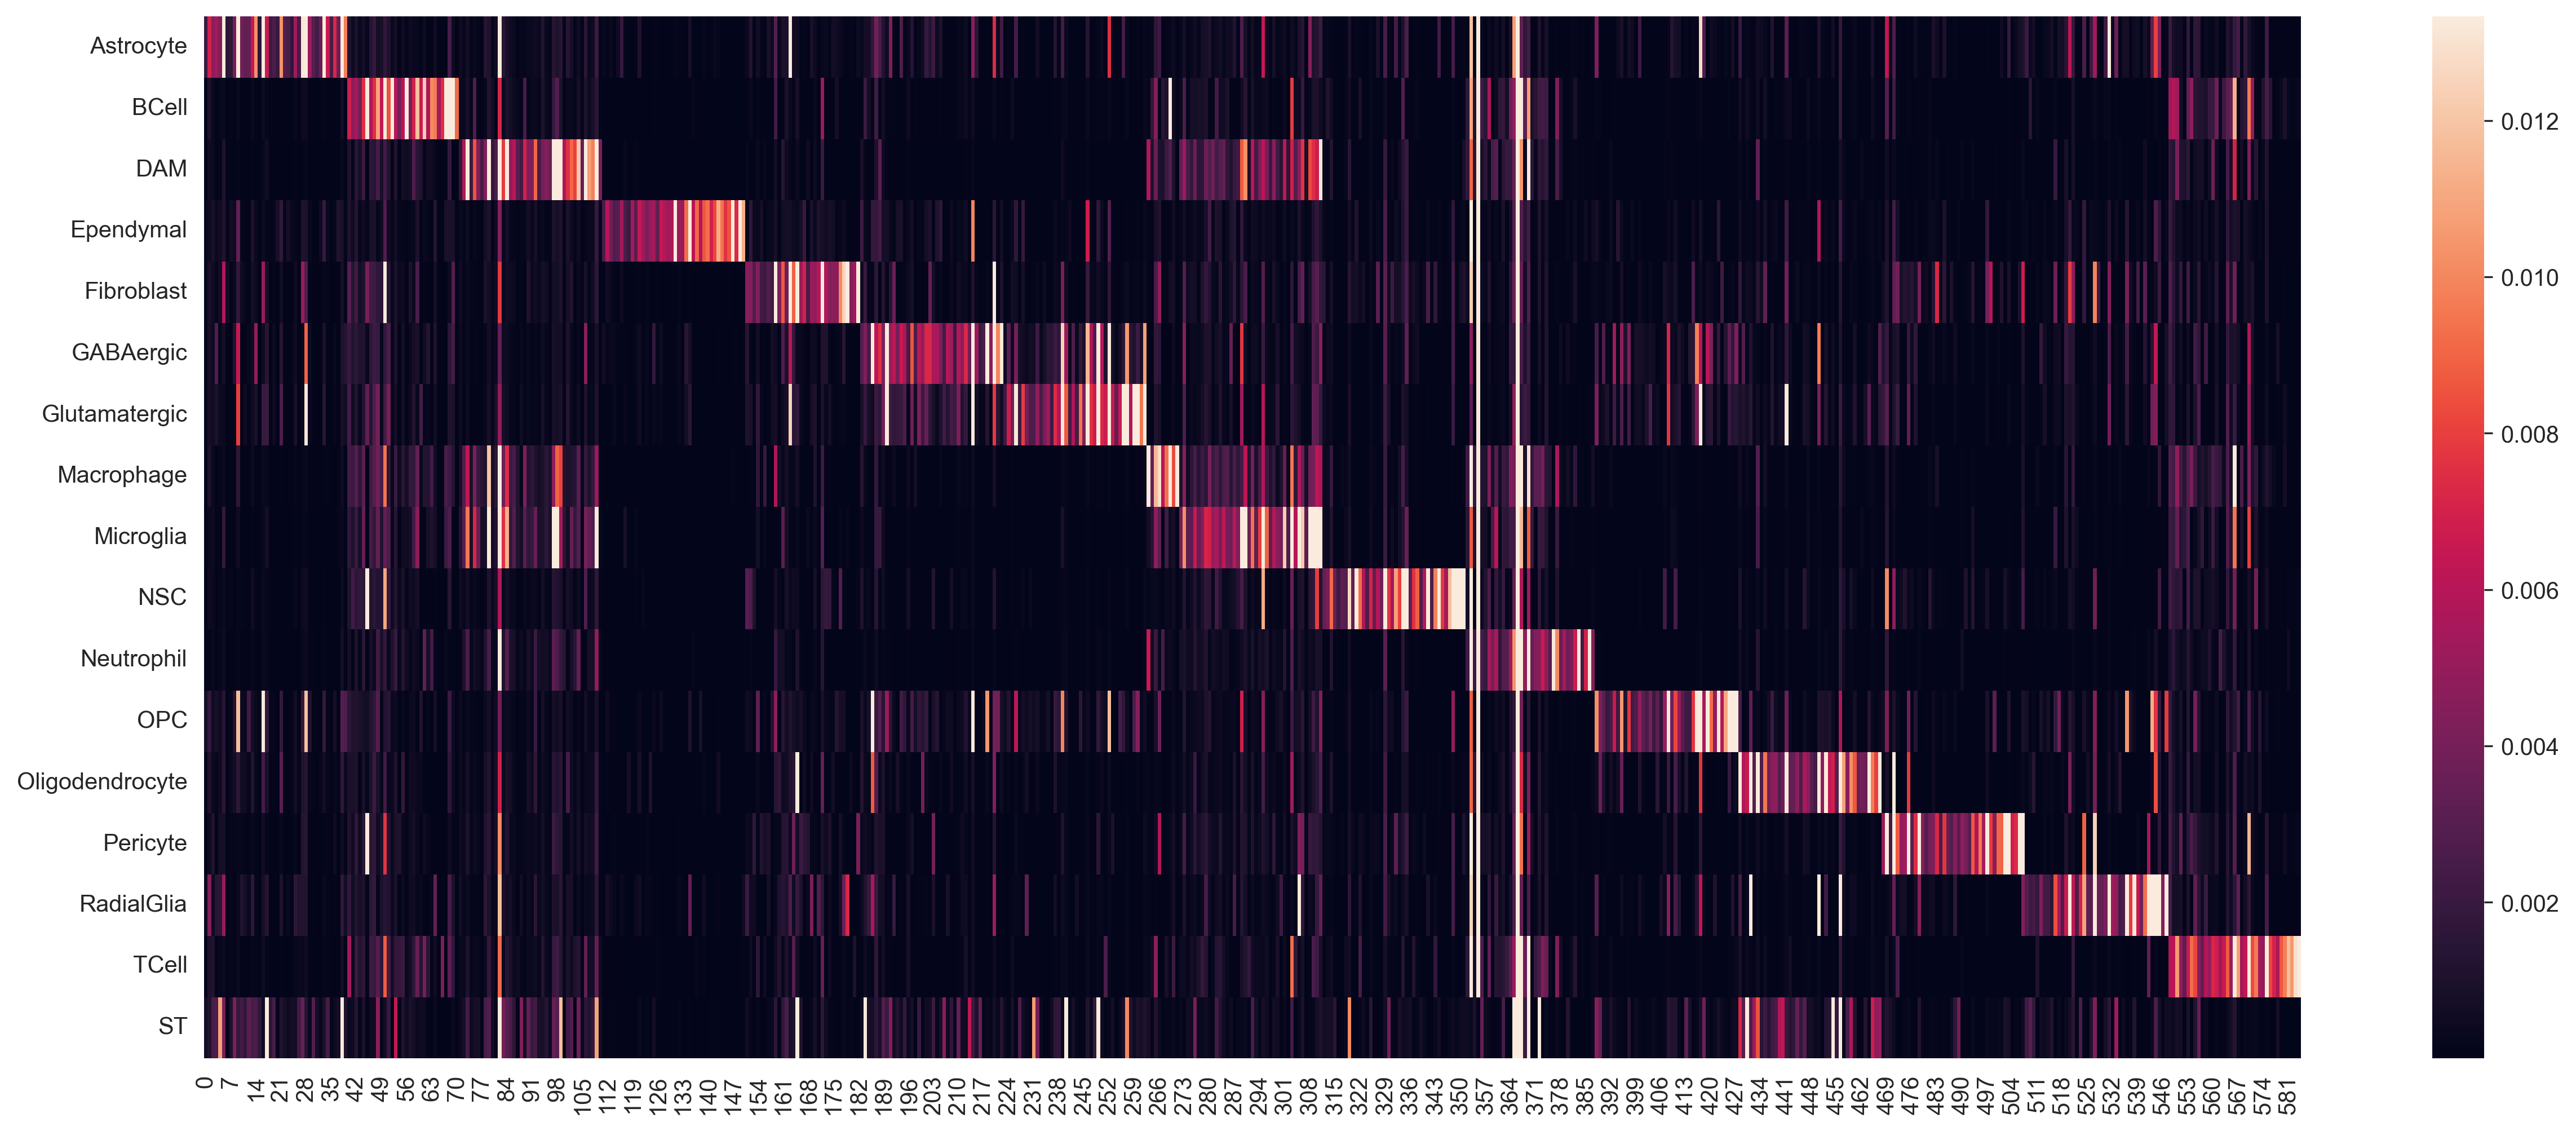

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
ST = adata_st.X
ST = np.sum(ST, axis=0)
ST = ST/np.sum(ST)
plt.figure(figsize=(20,8), dpi=300)
sc_ref_df = pd.DataFrame(np.vstack([sc_ref, ST]), index=type_list+['ST'])
ax = sns.heatmap(sc_ref_df, robust=True)